<a href="https://colab.research.google.com/github/munnathecat/Session-6/blob/master/Assignment_6B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.models import Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConv2D
from keras.layers import Activation, Flatten, Dense, Dropout, Input
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import concatenate
from keras.utils import np_utils

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

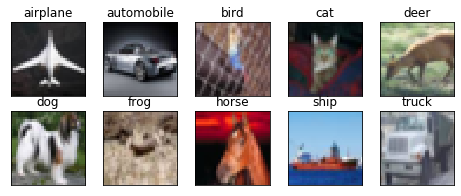

In [32]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
from keras.callbacks import Callback

class TerminateOnBaseline(Callback):
    """Callback that terminates training when either acc or val_acc reaches a specified baseline
    """
    def __init__(self, monitor='val_acc', baseline=0.9):
        super(TerminateOnBaseline, self).__init__()
        self.monitor = monitor
        self.baseline = baseline

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        acc = logs.get(self.monitor)
        if acc is not None:
            if acc >= self.baseline:
                print('Epoch %d: Reached baseline, terminating training' % (epoch))
                self.model.stop_training = True

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [37]:
# Define the model
#model = Sequential()
#X1
input = Input(shape=(32, 32, 3))
x1 = Convolution2D(32, (3, 3), border_mode='same', activation='relu', name='conv1') (input)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.1) (x1)

#x2 Spatially Separable Convolution  (Conv2d(x, (3,1)) followed by Conv2D(x,(3,1))
x2 = Convolution2D(64, (3, 1), border_mode='same', activation='relu', name='conv21') (x1)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.1)(x2)

x2 = Convolution2D(64, 1, 3, border_mode='same', activation='relu', name='conv22') (x2)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.1)(x2)

x2 = MaxPooling2D(pool_size=(2, 2)) (x2)

#16
#X3 Depthwise Separable Convolution
x3 = SeparableConv2D(128, kernel_size= 3, strides = 1, border_mode='same', activation='relu', name='conv3') (x2)
x3 = BatchNormalization() (x3)
x3 = Dropout(0.1)(x3)
x3 = MaxPooling2D(pool_size=(2, 2)) (x2)

#8
#x4 Grouped Convolution (use 3x3, 5x5 only)
 
x4 = Convolution2D(32, 3, 3, border_mode='same', activation='relu', name='conv41') (x3)
x4 = BatchNormalization() (x4)
x4 = Dropout(0.1) (x4)

x5 = Convolution2D(32, 5, 5, border_mode='same', activation='relu', name='conv42') (x3)
x5 = BatchNormalization() (x5)
x5 = Dropout(0.1) (x5)

merge = concatenate ([x4,x5])
 

#8
# Grouped Convolution (use 3x3 only, one with dilation = 1, and another with dilation = 2)

x6 = Convolution2D(64, 3, 3, dilation_rate =1, border_mode='same', activation='relu', name='conv51') (merge)
x6 = BatchNormalization() (x6)
x6 = Dropout(0.1) (x6)

x7 = Convolution2D(64, 3, 3, dilation_rate =2, border_mode='same', activation='relu', name='conv52') (merge)
x7 = BatchNormalization() (x7)
x7 = Dropout(0.1) (x7)

merge = concatenate ([x6,x7])


x8 = Convolution2D(num_classes, 8, activation='relu') (merge)
x9 = Flatten() (x8)

model = Model(inputs=[input], outputs=x9)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", name="conv1", padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 1), activation="relu", name="conv21", padding="same")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 3), activation="relu", name="conv22", padding="same")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(128, kernel_size=3, strides=1, activation="relu", name="conv3", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Ke

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), dilation_rate=1, activation="relu", name="conv51", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), dilation_rate=2, activation="relu", name="conv52", padding="same")`


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 32)   896         input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 32, 32, 32)   128         conv1[0][0]                      
__________________________________________________________________________________________________
dropout_34 (Dropout)            (None, 32, 32, 32)   0           batch_normalization_36[0][0]     
____________________________________________________________________________________________

In [38]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 32)   896         input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 32, 32, 32)   128         conv1[0][0]                      
__________________________________________________________________________________________________
dropout_34 (Dropout)            (None, 32, 32, 32)   0           batch_normalization_36[0][0]     
____________________________________________________________________________________________

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<__main__..., steps_per_epoch=390, epochs=50)`
  if sys.path[0] == '':




Epoch 1/50
390/390 [==============================] - 20s 50ms/step - loss: 2.2096 - acc: 0.3073 - val_loss: 2.5766 - val_acc: 0.3635
Epoch 2/50
390/390 [==============================] - 10s 26ms/step - loss: 1.8785 - acc: 0.3545 - val_loss: 4.9357 - val_acc: 0.2298
Epoch 3/50
390/390 [==============================] - 10s 26ms/step - loss: 1.8451 - acc: 0.3709 - val_loss: 2.2744 - val_acc: 0.3877
Epoch 4/50
390/390 [==============================] - 10s 26ms/step - loss: 1.9229 - acc: 0.3265 - val_loss: 4.3869 - val_acc: 0.2603
Epoch 5/50
390/390 [==============================] - 10s 26ms/step - loss: 1.8496 - acc: 0.3454 - val_loss: 2.8813 - val_acc: 0.3389
Epoch 6/50
390/390 [==============================] - 10s 26ms/step - loss: 1.7980 - acc: 0.3873 - val_loss: 2.7150 - val_acc: 0.3681
Epoch 7/50
390/390 [==============================] - 10s 26ms/step - loss: 1.8132 - acc: 0.3739 - val_loss: 2.5922 - val_acc: 0.3360
Epoch 8/50
390/390 [==============================] - 10s 26

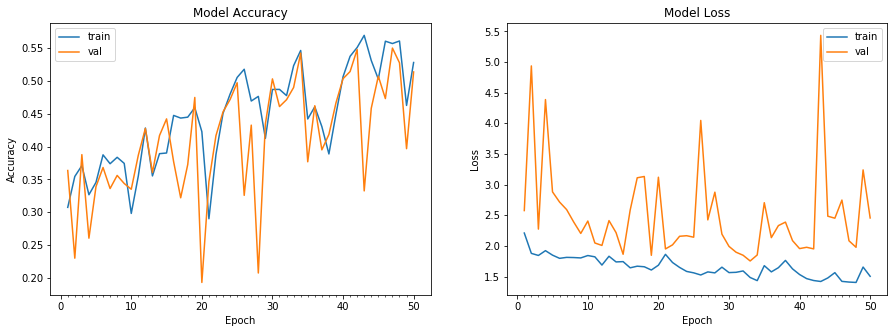

Accuracy on test data is: 51.38


In [39]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1, callbacks=[TerminateOnBaseline(monitor='val_acc', baseline=0.8415)])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))